# Оценка риска ДТП

**Описание задачи:**

Заказчик из каршеринговой компании предложил разработать систему, которая будет оценивать риск ДТП на выбранном маршруте. Риск подразумевает вероятность происшествия с любым повреждением транспортного средства. После того как водитель забронирует автомобиль, сядет за руль и выберет маршрут, система должна оценить уровень риска. Если риск высок, водитель получит предупреждение и рекомендации по маршруту.

На данный момент идея находится на стадии предварительного обсуждения, и чёткого алгоритма или аналогичных решений на рынке нет. Основная задача — понять, возможно ли предсказать ДТП, опираясь на исторические данные из одного из регионов.


**Создание модели предсказания ДТП:**

Модель будет прогнозировать, кто является виновником ДТП (целевое значение — at_fault в таблице parties).
Для модели выберется тип виновника — только автомобиль (car).
Учитываются случаи, когда ДТП привело к повреждениям транспортного средства, исключая тип SCRATCH (царапина).
Для моделирования используются только данные за 2012 год, так как они являются самыми свежими.
Важным условием является учет фактора aа автомобиля.

**Исследование факторов ДТП:**

На основе созданной модели будет произведено исследование факторов, влияющих на ДТП.

**Ответы на вопросы:**

- Возможно ли создать адекватную систему оценки водительского риска при выдаче автомобиля?
- Какие ещё факторы следует учесть для точности модели?
- Нужно ли оснащать автомобили дополнительными датчиками или камерами для улучшения предсказания?

Задачи:

- Формирование и анализ моделей предсказания ДТП.
- Определение важных факторов, которые могут повлиять на вероятность аварии.
- Разработка рекомендаций по оснащению автомобилей для повышения точности прогнозирования.
- Проект предполагает использование исторических данных о ДТП для разработки эффективной системы, которая поможет каршеринговой компании в оценке рисков и предотвращении аварий на дорогах.

## Импорты

In [1]:
import warnings
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna
import pandas as pd
import phik
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from IPython.display import HTML, display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import (StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import create_engine
from tqdm import tqdm

## Подключитесь к базе. Загрузите таблицы sql

In [2]:
SEED = 12345

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(*db_config.values())
engine = create_engine(db_connection)

In [4]:
query = '''
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'public';
'''
tables = pd.read_sql_query(query, engine)
tables


,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


Все необходимые таблицы существуют.

In [5]:
parties_query = '''
SELECT *
FROM parties
ORDER BY RANDOM()
LIMIT 10
'''
pd.read_sql_query(parties_query, con=engine, index_col='id')

,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
id,,,,,,,,
1877987,5166542,3,car,0,52.0,had not been drinking,None,0.0
1734674,5089506,2,car,0,53.0,had not been drinking,None,0.0
988707,4655034,1,car,1,25.0,had not been drinking,None,0.0
1190463,4780473,1,car,1,31.0,"had been drinking, under influence",None,0.0
2371218,5435829,1,car,1,NaN,impairment unknown,G,0.0
125793,4144664,3,car,1,32.0,had not been drinking,None,0.0
1436051,4920388,1,car,1,71.0,had not been drinking,None,0.0
2512030,5511432,2,road bumper,0,NaN,not applicable,not applicable,NaN
838166,4566256,2,car,0,30.0,had not been drinking,None,0.0


Загрузка данных прошла успешно

## Проведите первичное исследование таблиц

In [6]:
parties_dtypes_query = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'parties';
'''
pd.read_sql_query(parties_dtypes_query, con=engine, index_col='column_name')

,data_type
column_name,
cellphone_in_use,integer
party_number,integer
at_fault,integer
insurance_premium,integer
id,integer
case_id,text
party_drug_physical,text
party_type,text
party_sobriety,text


In [7]:
collisions_query = '''
SELECT *
FROM collisions
ORDER BY RANDOM()
LIMIT 10;
'''
pd.read_sql_query(collisions_query, con=engine, index_col='case_id')

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
case_id,,,,,,,,,,,,,,,,,,,
4551522,0791,contra costa,285.0,west,0,cloudy,None,small damage,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,daylight,none,2009-12-11,13:30:00
5083841,3703,san diego,0.0,None,0,clear,None,scratch,2,vehicle code violation,wrong side of road,broadside,bicycle,dry,normal,daylight,functioning,2011-01-05,08:35:00
4689064,1005,fresno,0.0,None,1,cloudy,None,scratch,1,vehicle code violation,speeding,other,other object,wet,normal,daylight,functioning,2010-04-21,13:13:00
4821819,3050,orange,561.0,east,0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2010-07-30,15:20:00
4811349,1942,los angeles,0.0,None,1,clear,None,severe damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,daylight,functioning,2010-07-02,10:15:00
4146882,1942,los angeles,0.0,None,1,clear,None,small damage,2,vehicle code violation,speeding,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2009-03-02,22:11:00
4319346,1941,los angeles,50.0,south,0,clear,highway,middle damage,1,vehicle code violation,dui,hit object,fixed object,dry,reduced width,dark with no street lights,none,2009-05-17,02:40:00
4464531,4807,solano,0.0,None,1,clear,None,small damage,2,vehicle code violation,improper turning,rear end,other motor vehicle,dry,normal,dusk or dawn,functioning,2009-10-22,17:56:00
4214824,1953,los angeles,0.0,None,1,cloudy,None,small damage,2,vehicle code violation,traffic signals and signs,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-04-27,08:50:00


In [8]:
collisions_dtypes_query = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'collisions';
'''
pd.read_sql_query(collisions_dtypes_query,
                  con=engine, index_col='column_name')

,data_type
column_name,
party_count,integer
intersection,integer
distance,real
collision_date,date
collision_time,time without time zone
location_type,text
collision_damage,text
case_id,text
pcf_violation_category,text


In [9]:
vehicles_query = '''
SELECT *
FROM vehicles
ORDER BY RANDOM()
LIMIT 10;
'''
pd.read_sql_query(vehicles_query, con=engine, index_col='id')

,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
id,,,,,
646269,4776816,1,sedan,auto,6
128074,4217912,1,sedan,auto,13
367086,4464358,1,sedan,auto,2
1286254,5413816,2,sedan,manual,9
504253,4620804,2,sedan,auto,6
681105,4816690,1,sedan,auto,2
747638,4878324,2,coupe,manual,10
933880,5073170,1,hatchback,manual,14
297448,4392001,3,hatchback,manual,8


In [10]:
vehicles_dtypes_query = '''
SELECT column_name,
       data_type
FROM information_schema.columns
WHERE table_name = 'vehicles';
'''
pd.read_sql_query(vehicles_dtypes_query, con=engine, index_col='column_name')

,data_type
column_name,
id,integer
party_number,integer
vehicle_age,integer
case_id,text
vehicle_type,text
vehicle_transmission,text


In [11]:
case_ids_query = '''
SELECT *
FROM case_ids
ORDER BY RANDOM()
LIMIT 10;
'''
pd.read_sql_query(case_ids_query, con=engine, index_col='case_id')

,db_year
case_id,
4451202,2021
5410516,2021
5606955,2021
4298484,2021
4759406,2021
4739181,2021
4660818,2021
5422009,2021
5259319,2021


In [12]:
case_ids_query = '''
SELECT db_year,
       COUNT(db_year)
FROM case_ids
GROUP BY db_year;
'''
pd.read_sql_query(case_ids_query, con=engine, index_col='db_year')

,count
db_year,
2021,1400000


### Вывод

- количество таблиц соответствует условию задачи;  
- все таблицы имеют набор данных;  
- `case_id` - общий ключ для связи таблиц.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные изучены, найден общий ключ.

##  Проведите статистический анализ факторов ДТП

In [13]:
per_month = '''
SELECT DATE_TRUNC('month', collision_date)::date AS collisions_month,
       COUNT(case_id) AS cases_count
FROM collisions
GROUP BY DATE_TRUNC('month', collision_date);
'''
cases_per_year = pd.read_sql_query(per_month, con=engine,
                                   index_col='collisions_month')

In [14]:
def get_barplot(df, col, fig_size=(15, 15)):
    plt.figure(figsize=fig_size)
    pal = sns.color_palette('Blues', df.shape[0])
    ax = sns.barplot(y=df.index, x=df[col], hue=df[col], orient='h',
                     palette=pal, order=df.index, dodge=False)
    plt.ylabel('Дата')
    plt.title(f'Количество ДТП')
    plt.yticks(fontsize=10)

    
    for item in ax.patches:
        if item.get_width():
            plt.text(item.get_width(), item.get_y(),
                     f'{item.get_width():.0f}', va='top',
                     fontsize=10)
    
   
    ax.get_legend().remove()

    
def get_barplot_m(df, col, fig_size=(15, 15)):
    plt.figure(figsize=fig_size)
    pal = sns.color_palette('Blues', df.shape[0])
    ax = sns.barplot(y=df.index, x=df[col], hue=df[col], orient='h',
                     palette=pal, order=df.index, dodge=False)
    plt.ylabel('Месяц')
    plt.title(f'Количество ДТП')
    plt.yticks(fontsize=10)

    
    for item in ax.patches:
        if item.get_width():
            plt.text(item.get_width(), item.get_y(),
                     f'{item.get_width():.0f}', va='top',
                     fontsize=10)
    
   
    ax.get_legend().remove()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

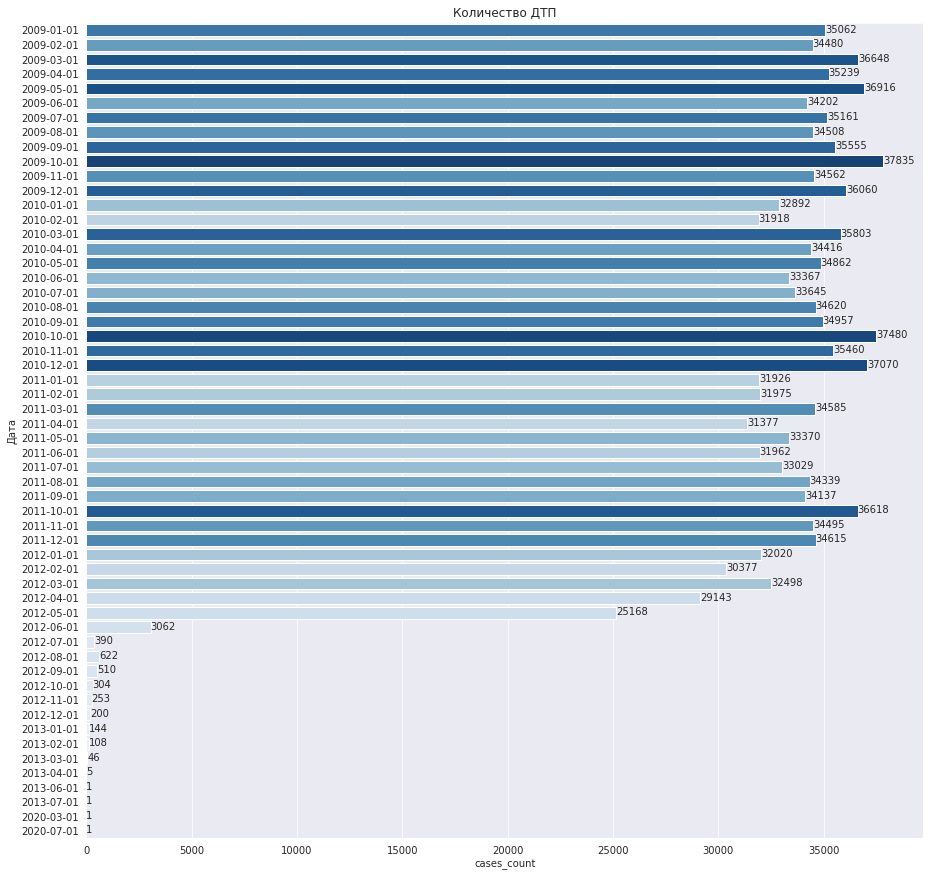

In [15]:
get_barplot(cases_per_year, 'cases_count')

После июня 2012 года поступало очень мало данных. Исключим всё после 12го года

In [16]:
per_month = '''
SELECT EXTRACT(MONTH FROM collision_date)::int AS collisions_month,
       COUNT(case_id) AS cases_count
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) <= 2012
GROUP BY EXTRACT(MONTH FROM collision_date)
ORDER BY cases_count DESC;
'''
cases_per_month = pd.read_sql_query(per_month, con=engine,
                                    index_col='collisions_month')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

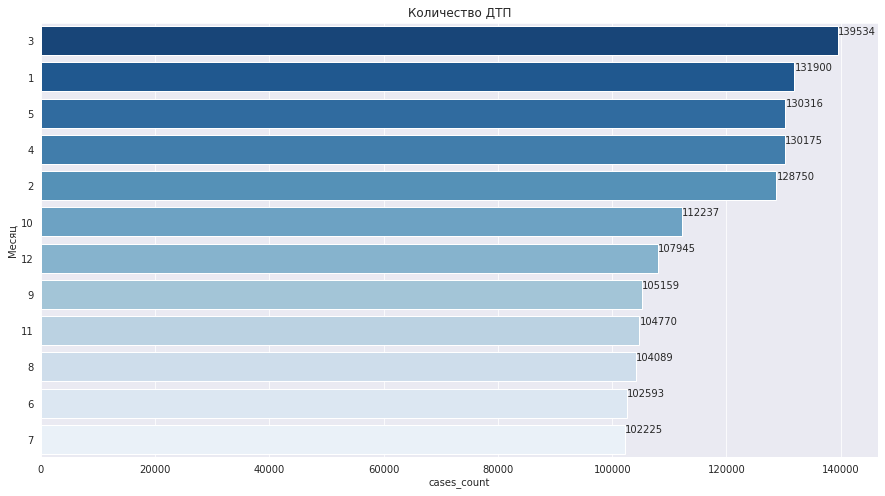

In [17]:
get_barplot_m(cases_per_month, 'cases_count', fig_size=(15, 8))

Наибольшее количество ДТП случается в весенний и зимний периоды, также одним из лидеров по количеству ДТП является октябрь.
Это может быть из-за погодных условий, таких как гололёд, мокрый асфальт, туман.

### Аналитические задачи для коллег

Задачи для коллег будут включать в себя анализ признаков с точки зрения целевой переменной, т.е. как на вероятность стать виновником ДТП повлияют следующие признаки:  
- Определите, на какизх видах дорог набиолее верятно ДТП (collisions)
- Проведите анализ серьезности повреждений от возраста автомобиля (collisions и vehicle)  
- Выясните, в какой диапазон времени происходит наибольшее количество аварий (collisions)
- Проведите анализ зависимости серьезности повреждений от физического состояния участника ДТП (collisions и parties)
- Проведите анализ частоты происшествий в зависимости от трезвости участника ДТП (collisions и parties)
- Проанализируйте количество ДТП в зависимости от состояния погоды (collisions)

#### Примеры решения задач

Порядок решения для двух задач будет идентичен:

- Напишите SQL запрос
- Проведите анализ и постройте график
- Сделайте вывод

Приведем пример решения двух задач:

- Проведите анализ серьезности повреждений от возраста автомобиля (collisions и vehicle)

- Проведите анализ зависимости серьезности повреждений от физического состояния участника ДТП (collisions и parties)

#### Задача 1

In [18]:
query = '''
SELECT v.vehicle_age AS age,
       c.collision_damage AS damage
       
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id
WHERE v.vehicle_age IS NOT NULL 
        AND c.collision_damage IS NOT NULL
'''

age_damage = pd.read_sql_query(query, con=engine)
age_damage.head()

,age,damage
0,8,small damage
1,11,scratch
2,6,small damage
3,3,small damage
4,7,scratch


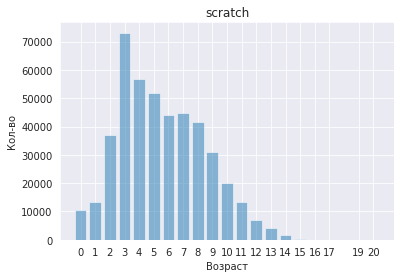

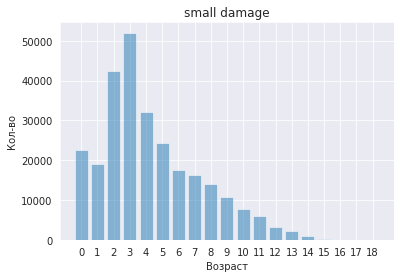

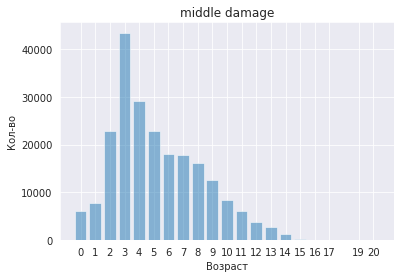

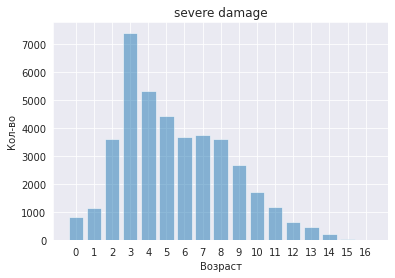

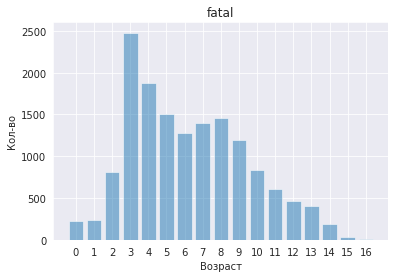

In [19]:
damage_vals = ['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']

for value in damage_vals:
    d = age_damage[(age_damage['damage'] == value) & (age_damage['age'] < 100)].groupby(['age']).count()
    plt.bar(d.index, d['damage'], alpha=.5)
    plt.xticks(list(d.index))
    plt.title(value)
    plt.ylabel('Кол-во')
    plt.xlabel('Возраст')
    plt.show()
    

Лидерами по ДТП среди всех видов повреждений оказались авто с возрастом 2-4 года.

Почти на всех графиках видно, что пересекая рубеж в 3 года частота повреждений уменьшается.

В категории small damage новые авто появляются чаще, чем в остальных категориях.

#### Задача 2

In [20]:
query = '''
WITH p AS(
SELECT * 
FROM parties
WHERE at_fault = 1
)

SELECT c.collision_damage,
        p.party_sobriety
FROM collisions AS c
JOIN p ON c.case_id = p.case_id
WHERE p.party_sobriety <> 'not applicable'
'''

sobriety_damage = pd.read_sql_query(query, con=engine)
sobriety_damage.head()

,collision_damage,party_sobriety
0,scratch,had not been drinking
1,fatal,had not been drinking
2,middle damage,impairment unknown
3,small damage,"had been drinking, under influence"
4,scratch,had not been drinking


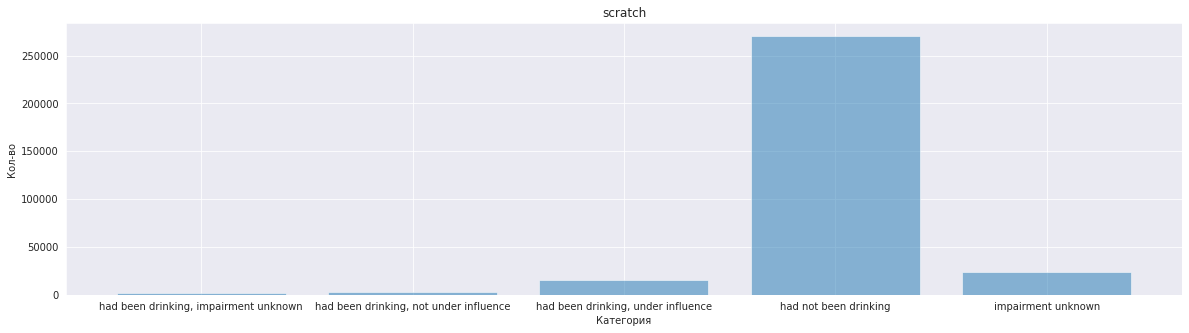

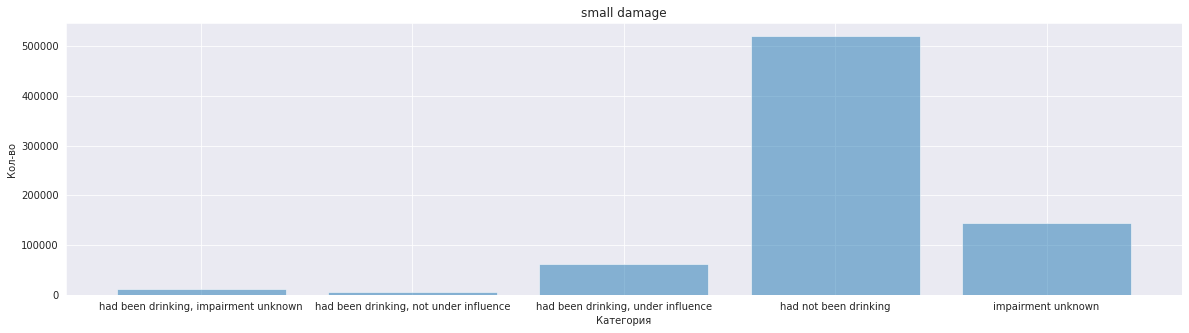

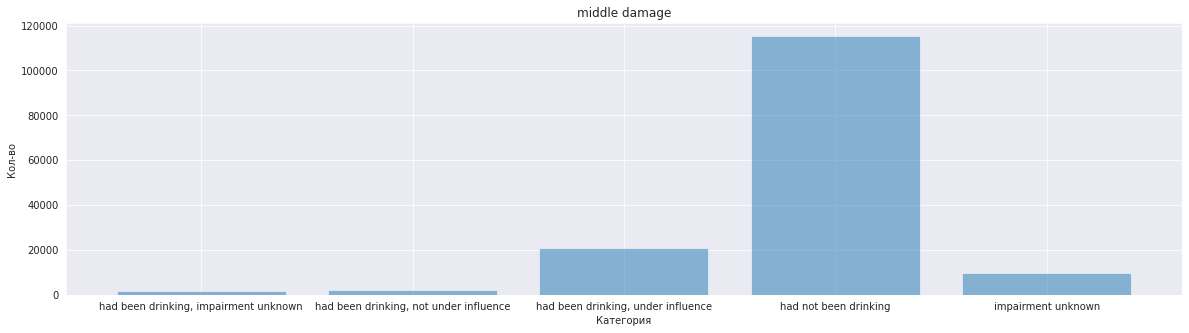

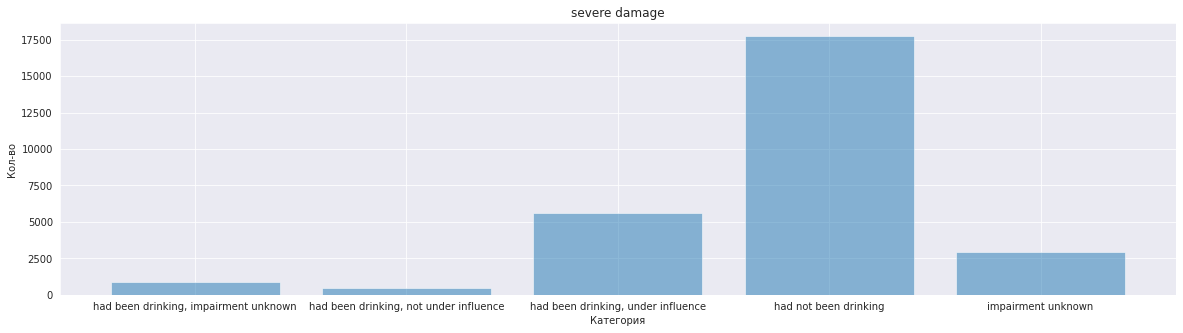

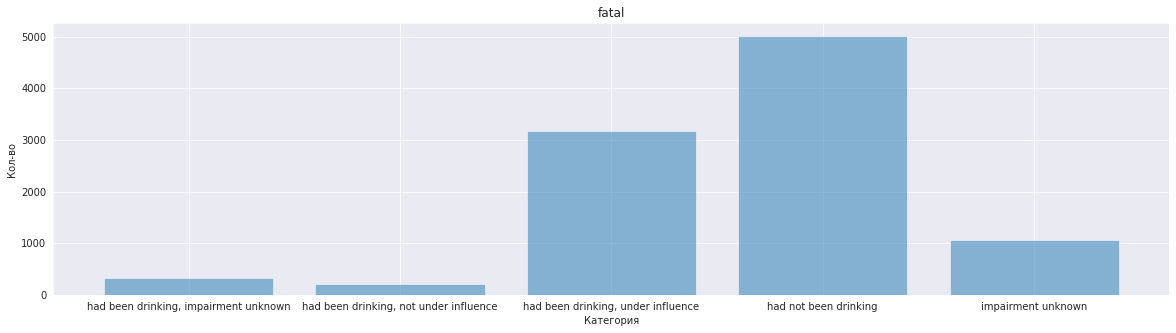

In [21]:
for value in damage_vals:
    d = sobriety_damage[(sobriety_damage['collision_damage'] == value)].groupby(['party_sobriety']).count()
    plt.figure(figsize=(20,5))
    plt.bar(d.index, d['collision_damage'], alpha=.5)
    plt.xticks()
    plt.title(value)
    plt.ylabel('Кол-во')
    plt.xlabel('Категория')
    plt.show()

В основном ДТП происходили по вине трезвых водителей.

Тем не менее видна закономерность: количество ДТП произошедших по вине пьяных водителей возрастает с тяжестью повреждений. Аварии с фатальными повреждениями чаще совершаются водителями в нетрезвом состоянии в процентном соотношении, чем другие виды аварий

## Создайте модель для оценки водительского риска

К воспроизводимым признакам относятся:
- vehicle_type — тип транспортного средства (можно определить до начала поездки).
- vehicle_transmission — тип трансмиссии (можно определить до начала поездки).
- vehicle_age — возраст транспортного средства (можно определить заранее).
- county_city_location — местоположение (можно зафиксировать на момент начала поездки).
- distance — расстояние (возможно, можно зафиксировать заранее в случае отслеживания маршрута).
- direction — направление (можно зафиксировать заранее).
- road_surface — тип дорожного покрытия (можно зафиксировать заранее).
- road_condition_1 — дорожные условия (можно зафиксировать заранее).
- c.weather_1 — погода (возможно установить заранее).
- lighting — освещенность (можно зафиксировать заранее, например, по времени суток).
- control_device — устройство управления (можно зафиксировать заранее).

In [22]:
query = '''
WITH parties_vehicles AS
    (SELECT v.vehicle_type,
            v.vehicle_transmission, 
            v.vehicle_age,
            p.*
    FROM parties AS p
    JOIN vehicles AS v ON p.case_id = v.case_id 
     AND p.party_number = v.party_number
    WHERE p.party_type = 'car')

SELECT c.county_city_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.road_surface,
       c.road_condition_1,
       c.lighting, 
       c.control_device,
       p_v.vehicle_type,
       p_v.vehicle_transmission, 
       p_v.vehicle_age,
       p_v.at_fault
FROM collisions AS c
JOIN parties_vehicles AS p_v ON c.case_id = p_v.case_id
WHERE EXTRACT(YEAR FROM c.collision_date) = 2012;

'''
df = pd.read_sql_query(query, con=engine)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103267 entries, 0 to 103266
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   county_city_location  103267 non-null  object 
 1   distance              103267 non-null  float64
 2   direction             75818 non-null   object 
 3   intersection          102918 non-null  float64
 4   weather_1             102962 non-null  object 
 5   location_type         43323 non-null   object 
 6   road_surface          102484 non-null  object 
 7   road_condition_1      102722 non-null  object 
 8   lighting              102934 non-null  object 
 9   control_device        102791 non-null  object 
 10  vehicle_type          103267 non-null  object 
 11  vehicle_transmission  101309 non-null  object 
 12  vehicle_age           100606 non-null  float64
 13  at_fault              103267 non-null  int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 11

In [24]:
size_before = df.shape[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103267 entries, 0 to 103266
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   county_city_location  103267 non-null  object 
 1   distance              103267 non-null  float64
 2   direction             75818 non-null   object 
 3   intersection          102918 non-null  float64
 4   weather_1             102962 non-null  object 
 5   location_type         43323 non-null   object 
 6   road_surface          102484 non-null  object 
 7   road_condition_1      102722 non-null  object 
 8   lighting              102934 non-null  object 
 9   control_device        102791 non-null  object 
 10  vehicle_type          103267 non-null  object 
 11  vehicle_transmission  101309 non-null  object 
 12  vehicle_age           100606 non-null  float64
 13  at_fault              103267 non-null  int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 11

In [25]:
def get_missing_values_percentage(df):
    percent_missing = df.isna().mean() * 100
    percent_missing.sort_values(inplace=True, ascending=False)
    return percent_missing.drop(percent_missing[percent_missing == 0].index)


def get_missing_values_barplot(df):
    temp = get_missing_values_percentage(df)
    plt.figure(figsize=(10, 5))
    pal = sns.color_palette('Blues', len(temp))
    ax = sns.barplot(y=temp.index, x=temp.values, hue=temp.index,
                     palette=pal[::-1], dodge=False)
    plt.ylabel('Признаки')
    plt.xlabel('Проценты')
    plt.title(f'Процент пропущенных значений по стобцам')
    plt.yticks(fontsize=12)
    for item in ax.patches:
        if not np.isnan(item.get_width()):
            plt.text(item.get_width(), item.get_y(),
                     f'{item.get_width():.1f}%', va='top',
                     fontsize=12)

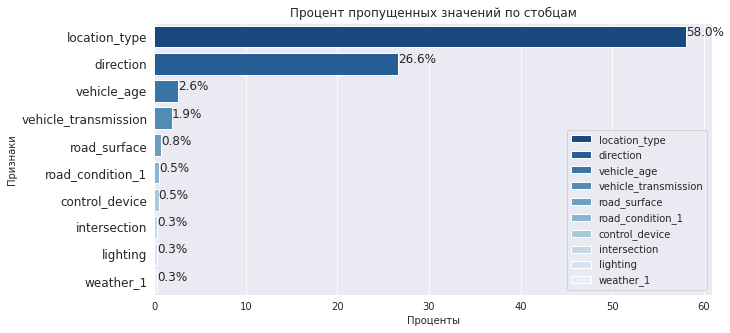

In [26]:
get_missing_values_barplot(df)

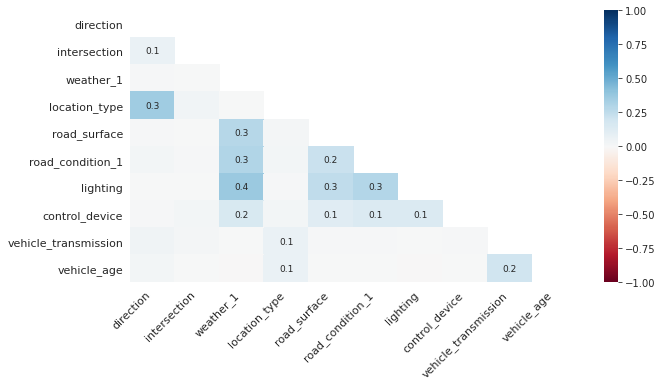

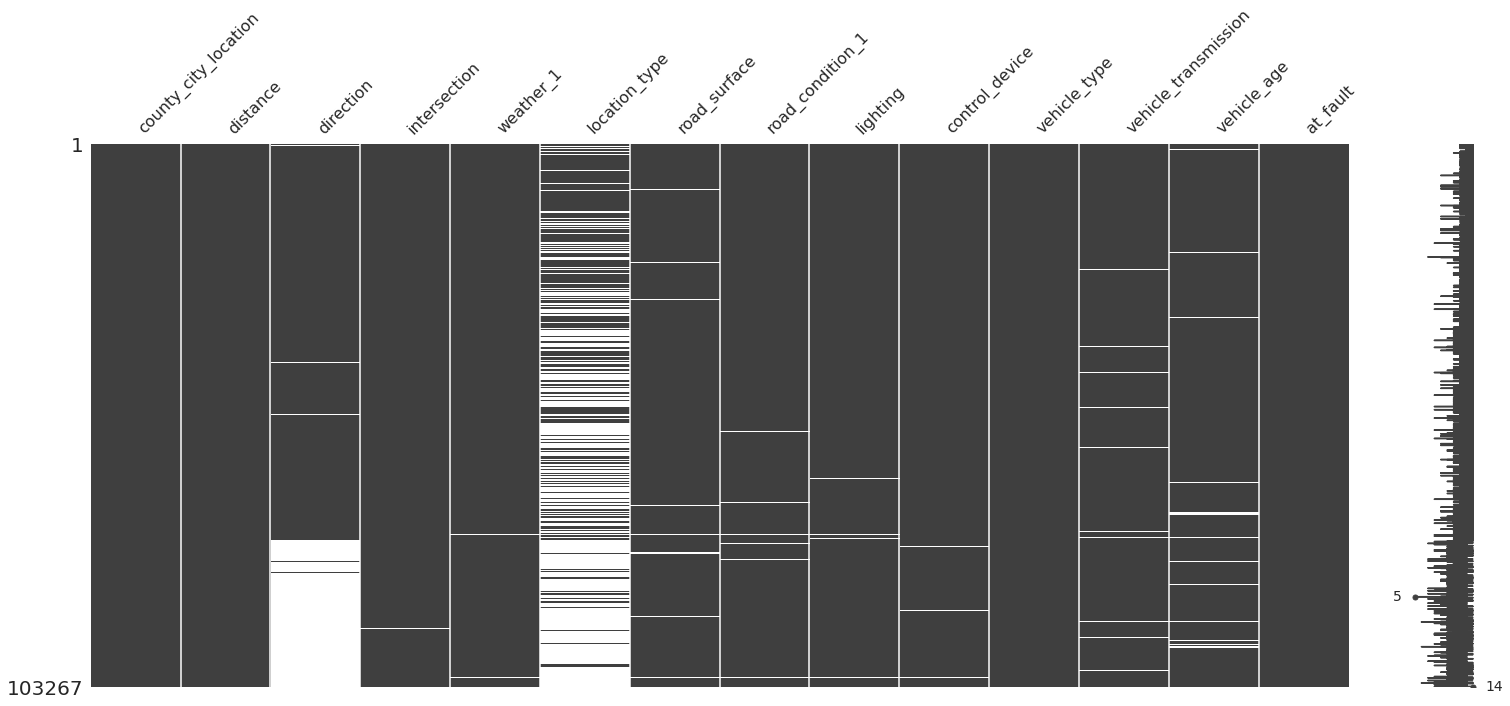

In [27]:
msno.heatmap(df, fontsize=11, figsize=(10, 5))
msno.matrix(df.sort_values(by='distance', ascending=False));

При увеличении значений переменной `distance` в данных появляются пропуски в столбце, который содержит информацию о направлении движения, а также увеличивается количество пропущенных значений в колонке `location_type`.

In [28]:
%%time
phik_overview = df.phik_matrix(interval_cols=['distance', 'insurance_premium'])

CPU times: user 9.47 s, sys: 0 ns, total: 9.47 s
Wall time: 9.49 s


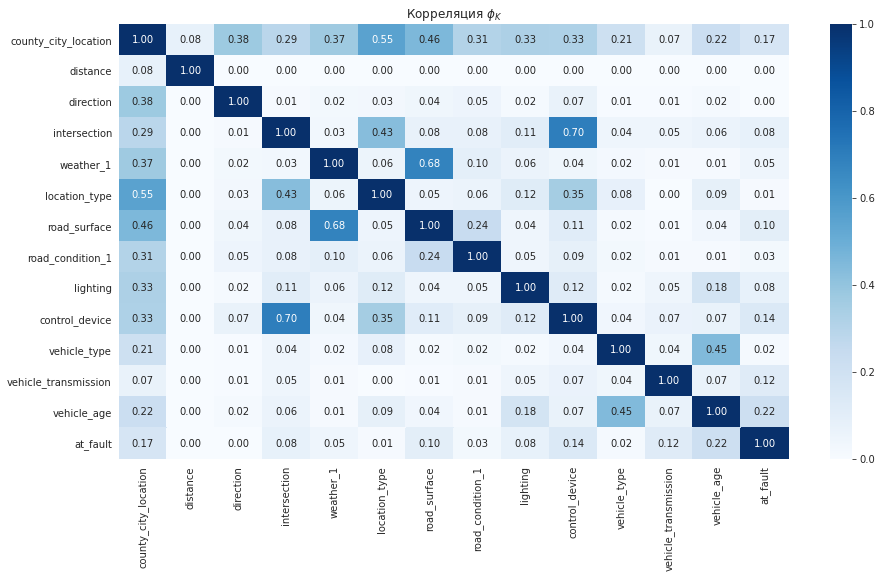

In [29]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=phik_overview, fmt='.2f', cmap='Blues', annot=True)
plt.title('Корреляция $\phi_K$')
plt.show()

Для категории нарушения и основного фактора аварии коэффициент Фи равен 1, также сильная корреляция между суммой страховки и возрастом автомобиля.  
Наиболее заметная взаимосвязь с целевой переменной наблюдается у следующих признаков:  
- `vehicle_age` - 0.18;
- `vehicle_transmission` - 0.15.

In [30]:
title_dict = {
    'vehicle_age': ['Возраст автомобиля (в годах)',
                    'возраста автомобиля'],
    'distance_cat': ['Расстояние от главной дороги (в метрах)',
                 'расстояния от главной дороги'],
    'weather_1': ['Погода', 'погоды'],
    'direction': ['Направление движения', 'направления движения'],
    'location_type': ['Тип дороги', 'типа дороги'],
    'vehicle_transmission': ['Тип КПП', 'типа КПП'],
    'vehicle_type': ['Тип кузова', 'типа кузова']
}


def get_temp(df, col, target='at_fault', num=None):
    temp = df.pivot_table(index=col, values=target, aggfunc=('count', 'mean'))
    temp = temp.sort_values(by='count', ascending=False)
    temp[target] = temp['count'] * temp['mean']
    temp['not_at_fault'] = temp['count'] - temp[target]
    temp = temp.sort_values(by='count', ascending=False)[:num]
    percentage = temp['mean'] * 100
    columns_dict = {
        target: 'Является виновником ДТП',
        'not_at_fault': 'Не является виновником ДТП'
    }
    temp = temp.rename(columns=columns_dict)
    temp = temp.drop(['count', 'mean'], axis=1).melt(ignore_index=False)
    

    percentage_second = [100 - x for x in percentage]
    percentage = list(percentage.values) + percentage_second
    return percentage, temp


def draw_barplot(temp, prcnt, col, title, fig_size=(15, 5), rot=None):
    plt.figure(figsize=fig_size)
    length = temp.shape[0] // 2
    ax = sns.barplot(data=temp, x=temp.index, y='value', palette='Blues',
                     order=temp.index[:length], hue='variable')
    for p, percent in zip(ax.patches, prcnt):
        ax.annotate(f'{percent: .2f}%', (p.get_x(), p.get_height() * 1.005))
    if rot:
        plt.xticks(rotation=rot, ha='center')
        
    plt.ylabel('Количество')
    plt.xlabel(title_dict[col][0])
    plt.title(f'Доля виновников ДТП в зависимости от {title_dict[col][1]}')
    plt.legend(title='')
    plt.grid(True)
    plt.show()


def get_barplot(df, col, title=None, num=None, fig_size=(15, 5), rot=None):
    percentage, temp = get_temp(df=df, col=col, num=num)
    draw_barplot(temp, percentage, col, title, fig_size, rot)

In [31]:
def get_histogram(data, col, f_size=(15, 5), bins_num=20, plot_style='-'):
    fig, axs = plt.subplots(2, 1, figsize=(f_size), sharex=True,
                            gridspec_kw={'height_ratios': [3, 1]})
    median = data[col].median()
    mean = data[col].mean()
    ax = axs[0]
    sns.histplot(data[col], bins=bins_num, ax=ax, edgecolor='white',
                 label='Общее количество ДТП', kde=True, stat='density')  # Нормировка
    sns.histplot(
        data.query('at_fault == 1')[col], bins=bins_num,
        edgecolor='white', color='sandybrown', label='Виновники ДТП',
        ax=ax, alpha=.5, kde=True, stat='density',  # Нормировка
    )

    ax.legend(loc='upper left')
    ax.set_ylabel('Плотность распределения') 
    ax.grid(True)

    idx = col
    fractions = data.pivot_table(index=idx, values='at_fault')
    fractions.columns = ['Доля виновников ДТП']
    ax = ax.twinx()
    fractions.plot(style=plot_style, c='cadetblue', alpha=.7, ax=ax)
    ax.set_ylabel('Доля виновников ДТП', labelpad=5, ha='center')
    ax.legend(loc='upper right')
    ax.grid(False)

    red_circle = dict(markerfacecolor='red', marker='o',
                      markeredgecolor='white')
    ax = axs[1]
    data[col].plot.box(flierprops=red_circle, ax=ax, vert=False)
    ax.set_yticks([])
    ax.set_xlabel(title_dict[col][0])
    plt.title(f'Распределение {title_dict[col][1]}')
    plt.tight_layout()


### Тип дороги

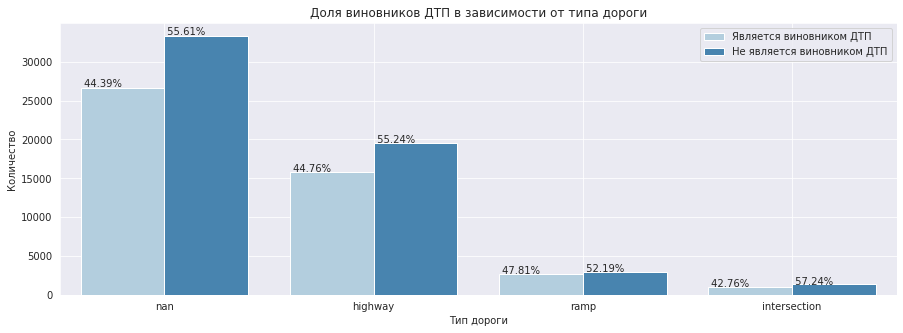

In [32]:
get_barplot(df.fillna(value='nan'), 'location_type')

In [33]:
df['location_type'] = df['location_type'].fillna('unknown')

Рампа лидирует по доле виновников ДТП.  
Пропуски заполним значением `unknown`.

### Направление движения

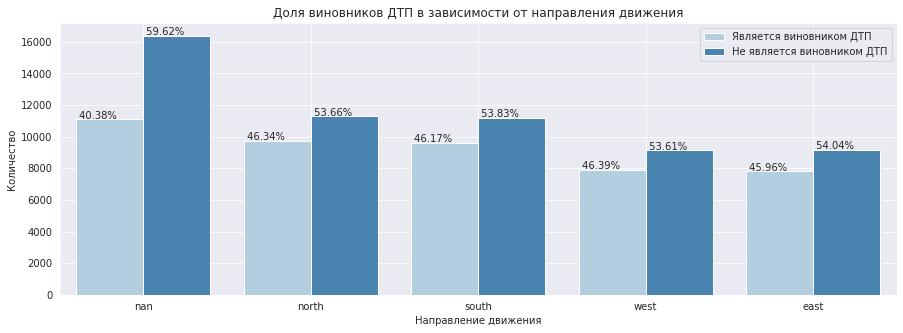

In [34]:
get_barplot(df.fillna(value='nan'), 'direction')

In [35]:
df['direction'] = df['direction'].fillna(value='unknown')

Статистически значимые различия в доле виновников ДТП между классами отсутствуют.   
Пропуски заполним значением `unknown`.

### Тип коробки передач

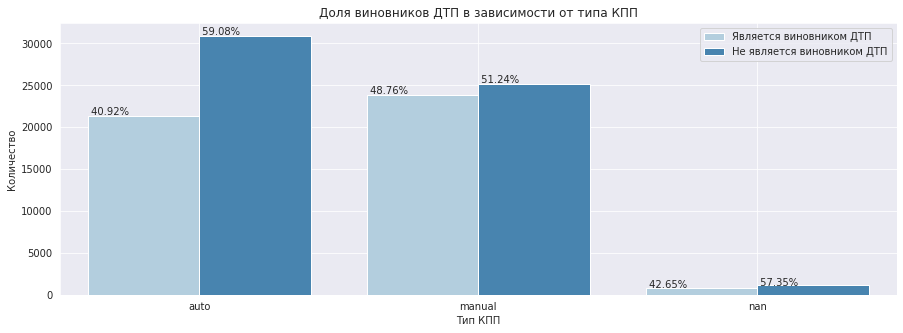

In [36]:
get_barplot(df.fillna('nan'), 'vehicle_transmission')

In [37]:
df['vehicle_transmission'] = df['vehicle_transmission'].fillna('auto')

У водителей, использующих автомобили с механической коробкой передач, вероятность стать виновником аварии выше. Поскольку механическая коробка передач является редкостью в США, человек, заполнявший информацию, мог посчитать необязательным указывать тип трансмиссии. Заполним пропуски значением `auto`.

### Тип кузова

,sedan,coupe,other
vehicle_type,52350,50895,22


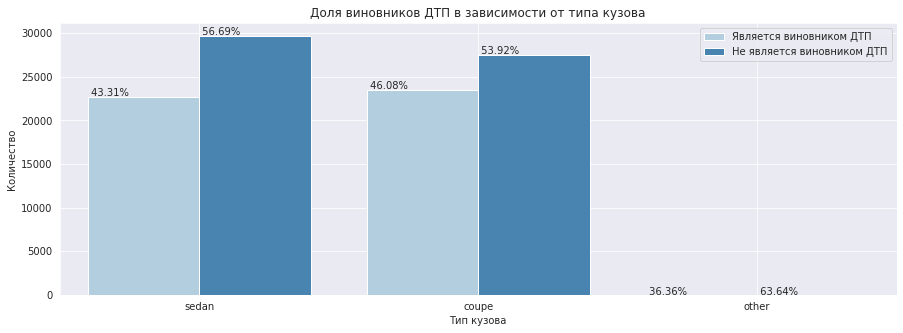

In [38]:
display(df['vehicle_type'].value_counts().to_frame().T)
get_barplot(df, 'vehicle_type')

### Расстояние от главной дороги

In [39]:
df['distance_cat'] = pd.cut(
    df['distance'], bins=5000, labels=list(range(5000))
)
df['distance_cat'] = \
    df.groupby('distance_cat', observed=False)['distance'].transform('mean')

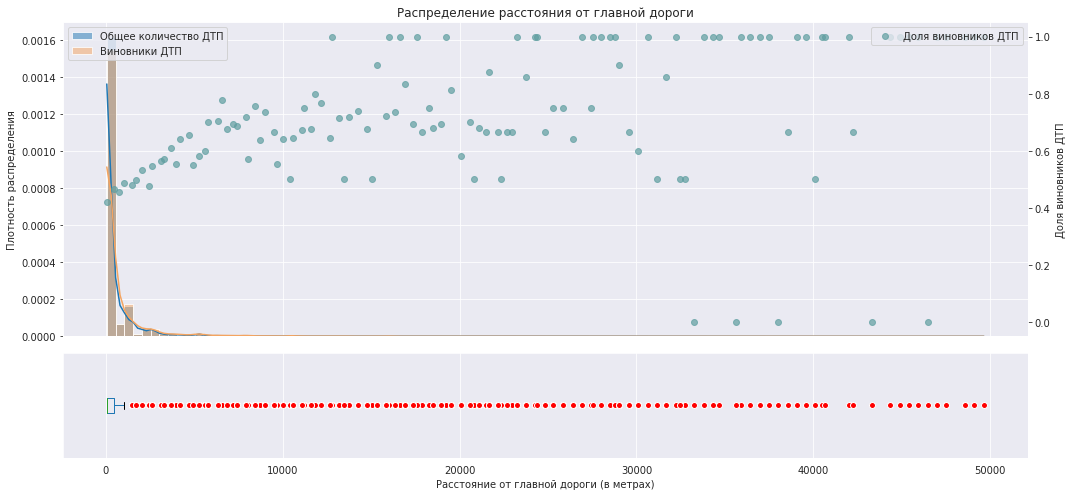

In [40]:
get_histogram(df.query('distance_cat < 50000'), 'distance_cat', bins_num=100,
              f_size=(15, 7), plot_style='o')

Значения, превышающие 13 тыс. метров, можно считать выбросами. Удалим их после разделения на выборки

### Возраст автомобиля

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,161.0
vehicle_age,4222,3705,9146,18521,13123,11024,8385,8363,7847,6133,4165,2835,1595,998,467,65,6,3,1,2


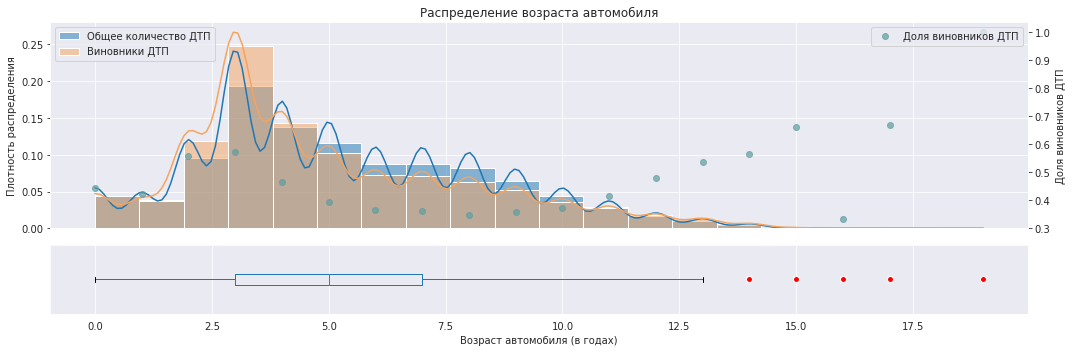

In [41]:
display(df['vehicle_age'].value_counts().sort_index().to_frame().T)
get_histogram(df.query('vehicle_age < 20'), 'vehicle_age', plot_style='o')

Автомобиль возрастом 161 год является аномалией удалим его после разделения на выборки.  
Вероятность оказаться виновником ДТП снижается при возрасте машины выше трёх лет и начинает увеличиваться при возрасте автомобиля, превышающем восем лет.  

In [42]:
df = df.dropna()
print(f'Явные дубликаты: {df.duplicated().sum()}')
df = df.drop_duplicates()
percentage = df.shape[0] / size_before * 100
print(f'Доля от изначального объёма данных: {percentage:.0f}%')

Явные дубликаты: 7713
Доля от изначального объёма данных: 88%


### Вывод

**Вывод**:    
- обработка пропусков:  
    - `direction`, `location_type`, - заполнены значением `unknown`;  
    - `vehicle_transmission` - значением `auto`;   
    - `vehicle_age` - модой в зависимости от географического района, типа кузова и типа КПП;  
    - пропуски в остальных столбцах были удалены;  
- после предобработки сохранилось примерно 88% данных;  

## Создайте модель для оценки водительского риска

In [43]:
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns] = \
    df[numeric_columns].apply(pd.to_numeric, downcast='integer')
float_columns = df.select_dtypes(include=['float']).columns
df[float_columns] = \
    df[float_columns].apply(pd.to_numeric, downcast='float')

In [44]:
df = df.reset_index(drop=True)
features = df.drop('at_fault', axis=1)
target = df['at_fault']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, stratify=target,
    test_size=.2, random_state=SEED
)

### Работа с train

Выше было установлено несколько проблем с данными:
- Значения расстояния от главной дороги, превышающие 13 тыс. метров, можно считать выбросами.
- Автомобиль возрастом 161 год является аномалией, также отсутсвуют возраста некоторых автомобилей, заполним их, сгруппировав данные по географическому району, типу кузова и типу КПП..

In [45]:
indices_to_remove = features_train[features_train['distance_cat'] > 13000].index

In [46]:
indices_to_remove

Int64Index([ 9715,  8391, 69597, 34212,  6230, 46249, 55440, 29489, 29308,
            44883,
            ...
            33398, 61808, 81196, 78734, 24722,  4495, 90393, 14587, 57392,
            15084],
           dtype='int64', length=506)

Удаление аномальных дистанций

In [47]:
features_train = features_train.drop(features_train.query('distance_cat > 13000').index, axis=0)
features_train = features_train.drop('distance_cat', axis=1)

In [48]:
target_train = target_train.drop(indices_to_remove)

Удаление аномального возраста

In [49]:
indices_to_remove = features_train[features_train['vehicle_age'] > 20].index

In [50]:
indices_to_remove

Int64Index([73984, 23077], dtype='int64')

In [51]:
features_train = features_train.drop(features_train.query('vehicle_age > 20').index, axis=0)

In [52]:
target_train = target_train.drop(indices_to_remove)

Заполнение пропусков

In [53]:
group_cols = ['county_city_location', 'vehicle_type', 'vehicle_transmission']
features_train['vehicle_age'] = (
    features_train.groupby(group_cols)['vehicle_age']
    .transform(lambda x: x.fillna(x.mode(dropna=True).get(0, float('nan'))))
)

#### Вывод


Отчистил выборку от аномалий, исходя из анализа, который был произведён ранее.

In [57]:
obj_selector = make_column_selector(dtype_include='object')

In [58]:
te_columns = [features_train.columns.get_loc(col)
              for col in obj_selector(features_train)]

In [59]:
features_train['county_city_location'] = \
    features_train['county_city_location'].astype('int16')
features_test['county_city_location'] = \
    features_test['county_city_location'].astype('int16')

In [60]:
def objective(trial,
              X_train=features_train, y_train=target_train,
              te_cols=te_columns, classifier='cat',
              depth=(10, 23), split=(26, 33), features=(2, 26)):
    if classifier == 'cat':
        cat_params = {
            'colsample_bylevel': trial.suggest_float(
                'colsample_bylevel', 0.01, 1
            ),
            'depth': trial.suggest_int('depth', 2, 7),
            'boosting_type': trial.suggest_categorical(
                'boosting_type', ['Ordered', 'Plain']
            ),
            'bootstrap_type': trial.suggest_categorical(
                'bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']
            ),
            'used_ram_limit': '3gb',
            'auto_class_weights': 'Balanced',
            'silent': True,
            'random_state': SEED,
            'thread_count': -1,
            'cat_features': te_cols
        }

        if cat_params['bootstrap_type'] == 'Bayesian':
            cat_params['bagging_temperature'] = trial.suggest_float(
                'bagging_temperature', 0, 10
            )
        elif cat_params['bootstrap_type'] == 'Bernoulli':
            cat_params['subsample'] = trial.suggest_float('subsample', 0.1, 1)

        clf = CatBoostClassifier(**cat_params)
        
        result = cross_val_score(
            clf, X_train, y_train, scoring='roc_auc', n_jobs=-1,
            cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
            error_score='raise'
        )
        return result.mean()

    if classifier == 'rf':
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 100),
            'max_depth': trial.suggest_int('max_depth', *depth),
            'max_features': trial.suggest_int('max_features', *features),
            'min_samples_split': trial.suggest_int('min_samples_split',
                                                   *split)
        }
        clf = RandomForestClassifier(n_jobs=-1, random_state=SEED,
                                     class_weight='balanced', **rf_params)

    else:
        lr_params = {
            'C': trial.suggest_float('C', 1e-3, 1),
            'max_iter': trial.suggest_int('max_iter', 100, 1000),
            'solver': trial.suggest_categorical(
                'solver', ['lbfgs', 'liblinear', 'sag', 'saga']
            ),
            'intercept_scaling': trial.suggest_int(
                'intercept_scaling', 1, 100
            ),
            'tol': trial.suggest_float('tol', 1e-3, 1)
        }
        clf = LogisticRegression(n_jobs=-1, random_state=SEED,
                                 class_weight='balanced', **lr_params)
    smoothing = trial.suggest_float('smoothing', 1e-3, 1)
    transformer = make_column_transformer(
        (TargetEncoder(smoothing=smoothing), te_cols),
        remainder='passthrough'
    )

    clf = make_pipeline(transformer, StandardScaler(), clf)
    result = cross_val_score(
        clf, X_train, y_train, scoring='roc_auc', n_jobs=-1,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
        error_score='raise'
    )
    return result.mean()

**Выбор метрик**

Для заказчика важна точность прогноза для принятия решений о риске ДТП, думаю, что основное внимание уделить метрикам ROC AUC (для оценки способности модели различать классы), F1-Score (для баланса точности и полноты), Recall (чтобы не пропускать опасные случаи)  и Precision (для минимизации ложных тревог).

In [61]:
#func = lambda trial: objective(trial)
#sampler = optuna.samplers.TPESampler(seed=SEED)
#cat_study = optuna.create_study(direction='maximize', sampler=sampler)
#cat_study.optimize(func, n_trials=50, show_progress_bar=True)

In [62]:
#func = lambda trial: objective(trial, classifier='rf')
#sampler = optuna.samplers.TPESampler(seed=SEED)
#rf_study = optuna.create_study(direction='maximize', sampler=sampler)
#rf_study.optimize(func, n_trials=50, show_progress_bar=True)

In [63]:
#func = lambda trial: objective(trial, classifier='lr')
#sampler = optuna.samplers.TPESampler(seed=SEED)
#lr_study = optuna.create_study(direction='maximize', sampler=sampler)
#lr_study.optimize(func, n_trials=20, show_progress_bar=True)

In [64]:
#rf_params= rf_study.best_params
rf_params = {'n_estimators': 95,
             'max_depth': 14,
             'max_features': 6,
             'min_samples_split': 27,
             'smoothing': 0.568157304052605}

#lr_params = lr_study.best_params
lr_params = {'C': 0.40573052934726894,
             'max_iter': 412,
             'solver': 'liblinear',
             'intercept_scaling': 13,
             'tol': 0.5682887891078429,
             'smoothing': 0.40433307026180587}

#cat_params = cat_study.best_params
cat_params ={'colsample_bylevel': 0.9685597571118856,
             'depth': 5,
             'boosting_type': 'Plain',
             'bootstrap_type': 'MVS'}

In [65]:
metrics = ['roc_auc', 'f1', 'recall', 'precision']


def get_scores(params=cat_params, classifier='cat', te_cols=te_columns,
               X_train=features_train, y_train=target_train, metrics=metrics,
               thresh=0.5):
    params = params.copy()
    if classifier == 'cat':
        class CatBoostTH(CatBoostClassifier):

            def predict(self, data, threshold=thresh):
                return self.predict_proba(data)[:, 1] > threshold

        clf = CatBoostTH(
            **params, auto_class_weights='Balanced',
            cat_features=te_cols,
            silent=True, random_state=SEED, thread_count=-1
        )
        result = cross_validate(
            clf, X_train, y_train, n_jobs=-1, scoring=metrics,
            cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
            error_score='raise'
        )
        return [result[f'test_{metric}'].mean() for metric in metrics]

    smoothing = params.pop('smoothing') 
    if classifier == 'rf':
        clf = RandomForestClassifier(
            n_jobs=-1, random_state=SEED,
            class_weight='balanced', **params
        )
    else:
        clf = LogisticRegression(
            n_jobs=-1, random_state=SEED, **params,
            class_weight='balanced'
        )
    transformer = make_column_transformer(
        (TargetEncoder(smoothing=smoothing), te_cols),
        remainder='passthrough'
    )
    pipe = make_pipeline(transformer,
                         StandardScaler(), clf)
    result = cross_validate(
        pipe, X_train, y_train, n_jobs=-1,
        scoring=metrics,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True),
        error_score='raise'
    )
    return [result[f'test_{metric}'].mean() for metric in metrics]

In [66]:
%%time
cat_result = get_scores()
rf_result = get_scores(params=rf_params, classifier='rf')
lr_result = get_scores(params=lr_params, classifier='lr')

CPU times: user 10min 21s, sys: 4.28 s, total: 10min 25s
Wall time: 10min 34s


In [67]:
data = {
    'CatBoostClassifier': cat_result,
    'RandomForesClassifier': rf_result,
    'LogisticRegression': lr_result
}
cross_val_df = pd.DataFrame(data=data, index=metrics)
cross_val_df

,CatBoostClassifier,RandomForesClassifier,LogisticRegression
roc_auc,0.661700,0.642661,0.614288
f1,0.572596,0.554346,0.553783
recall,0.557496,0.537655,0.566487
precision,0.588572,0.572242,0.541671


CatBoostClassifier — лучшая модель среди представленных, так как она имеет наибольшие значения во всех метках, что свидетельствует о её высоком качестве работы - используем её в дальнейшем исследовании.   

In [68]:
%%time
best_threshold = 0.5
best_scores = None

threshold_range = np.arange(0.35, 0.39, 0.01)
for i in tqdm(reversed(threshold_range)):
    local_scores = get_scores(params=cat_params, thresh=i)
    if local_scores[-1] < 0.5:
        break
    best_scores = local_scores
    best_threshold = i

2it [27:03, 811.67s/it]

CPU times: user 26min 27s, sys: 9.71 s, total: 26min 37s
Wall time: 27min 3s


In [69]:
metrics.append('threshold')
best_scores.append(best_threshold)
data = {metric: score for metric, score in zip(metrics, best_scores)}
res = pd.DataFrame(data=data, index=['CatBoostClassifier'])
res = res.applymap('{0:.2f}'.format)
res

,roc_auc,f1,recall,precision,threshold
CatBoostClassifier,0.66,0.63,0.85,0.50,0.38


### Финальное тестирование

In [70]:
clf = CatBoostClassifier(
    **cat_params, auto_class_weights='Balanced',
    cat_features=te_columns,
    silent=True, random_state=SEED, thread_count=-1
)
clf.fit(features_train, target_train)

In [71]:
clf.set_probability_threshold(best_threshold)
predicted = clf.predict(features_test)

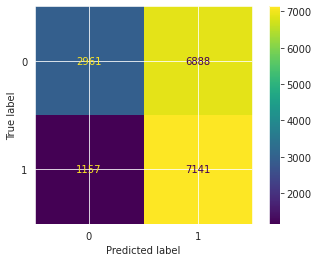

In [72]:
matrix = confusion_matrix(target_test, predicted)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot();

- True Positives (TP): 7141 — это количество случаев, когда модель правильно предсказала, что автомобиль виновен в ДТП.
- False Positives (FP): 6888 — это количество случаев, когда модель ошибочно предсказала, что автомобиль виновен, хотя на самом деле это не так.
- False Negatives (FN): 1157 — это количество случаев, когда модель не предсказала, что автомобиль виновен, хотя на самом деле это так.
- True Negatives (TN): 2961 — это количество случаев, когда модель правильно предсказала, что автомобиль не виновен.

Precision (Точность): Например, если точность составляет 0.51, это означает, что из всех случаев, когда модель предсказала, что автомобиль виновен, 51% из них действительно являются виновными. Это означает, что система склонна ошибочно считать автомобили виновными в ДТП в 49% случаев.

Recall (Полнота): Например, если полнота составляет 0.98, это означает, что модель обнаружила 98% всех случаев, когда автомобиль действительно был виновен в ДТП. Это означает, что система очень хороша в выявлении случаев с виновниками, но может ошибаться в их точной классификации.

F1-Score (Среднее гармоническое между Precision и Recall):Высокий F1-Score говорит о том, что система сбалансированно предсказывает ДТП с виновниками и минимизирует как ложные тревоги, так и пропущенные случаи.
Низкий F1-Score может указывать на то, что модель либо предсказывает слишком много ложных тревог (низкая точность), либо пропускает важные случаи (низкая полнота). Это может привести к излишним предупреждениям или наоборот — к недостаточной безопасности.

ROC AUC (Площадь под кривой ROC):Высокий ROC AUC (близкий к 1) означает, что система эффективно различает автомобили, виновные в ДТП, и те, кто не виновен. Это важно для системы, которая должна предупредить водителя о риске, точно отличая высокие риски от низких.
Низкий ROC AUC (близкий к 0.5) указывает на то, что модель плохо различает два класса, и её предсказания не лучше случайных.

1. Наличие ложных тревог (False Positives):

- Важно понимать, что хотя модель правильно предсказала виновников в 7141 случаях, она ошиблась и предупредила о высоком риске в 6759 случаях, когда на самом деле автомобиль не был виновен. Это может привести к излишним предупреждениям водителям, что может вызвать раздражение и снизить доверие к системе.

2. Пропущенные случаи (False Negatives):

- Особенно важен показатель 1157 ложных отрицательных предсказаний. Эти случаи показывают, что модель не предсказала, что автомобиль виновен, хотя на самом деле это было так. Это представляет собой потенциальный недостаток безопасности. Водители, возможно, не получили предупреждения о высоком риске, что может привести к авариям или опасным ситуациям.

3. Баланс между точностью и полнотой:

- В идеале нам нужно достичь хорошего баланса между точностью (предсказание, что автомобиль виновен, когда это действительно так) и полнотой (предсказание всех случаев, когда автомобиль действительно виновен). Слишком много ложных тревог (FP) может привести к потере доверия со стороны пользователей, в то время как недостаток полноты (FN) может увеличить риск реальных аварий, когда система не дает предупреждения.



In [73]:
def plot_roc_curve(roc_auc, probs, X_test=features_test,
                   y_test=target_test, threshold=best_threshold):
    fpr, tpr, thresh = roc_curve(y_test, probs)

    idx = np.argmin(abs(thresh - threshold))
    x_thresh, y_thresh = fpr[idx], tpr[idx]

    plt.figure(figsize=(7, 5))
    
    plt.plot(fpr, tpr, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], c='r', linestyle='--', label='Случайная модель')

    plt.axhline(y=y_thresh, c='black', ls=':')
    plt.axvline(x=x_thresh, c='black', ls=':')
    
    plt.text(x=.25, y=.6, s=f'Порог : {threshold:.2f}')
    plt.plot(x_thresh, y_thresh, 'ro')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()

              precision    recall  f1-score   support

           0       0.72      0.30      0.42      9849
           1       0.51      0.86      0.64      8298

    accuracy                           0.56     18147
   macro avg       0.61      0.58      0.53     18147
weighted avg       0.62      0.56      0.52     18147



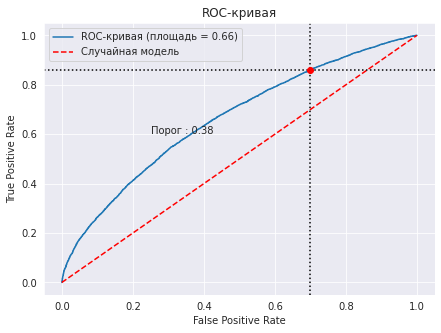

In [74]:
print(classification_report(target_test, predicted))
probs = clf.predict_proba(features_test)[:, 1]
roc_auc = roc_auc_score(target_test, probs)
plot_roc_curve(roc_auc, probs)

### Вывод

- проведён подбор гиперпараметров для трёх моделей: случайного леса, логистической регрессии и CatBoostClassifier;  
- на кросс-валидации лучший результат продемонстрировала модель CatBoostClassifier, поэтому была выбрана для дальнейшего исследования;  
- при пороге классификации равным 0.38 удаётся обнаружить примерно 84% потенциальных виновников ДТП.

## Проведите анализ важности факторов ДТП

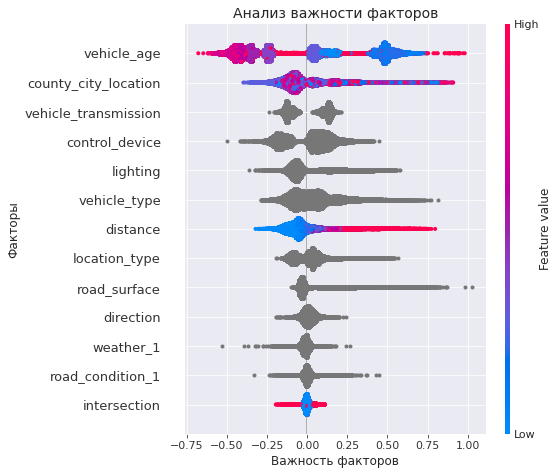

In [75]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(features_train.values)

plt.figure(figsize=(10, 8))

shap.summary_plot(shap_values, features_train, class_names=clf.classes_, show=False)


plt.title("Анализ важности факторов", fontsize=14)
plt.xlabel("Важность факторов", fontsize=12)
plt.ylabel("Факторы", fontsize=12)

plt.tight_layout()
plt.show()

1. Признаки, такие как `vehicle_age`, `county_city_location`, `vehicle_transmission` и `control_device`, имеют сильное влияние на прогноз модели. Изменения в этих признаках могут значительно изменять вероятность того, что автомобиль окажется виновным в ДТП.


2. Признаки, такие как `weather_1`, `road_surface` и `road_condition_1`, также оказывают влияние, но их влияние может быть менее выраженным по сравнению с возрастом автомобиля и местоположением.


#### Возраст автомобиля

,3,4,5,2,7,6,8,9,0,10,1,11,12,13,14,15,16,17,161,19
vehicle_age,16440,11700,9840,8305,7583,7542,7110,5534,3861,3845,3393,2640,1480,942,440,65,6,3,2,1


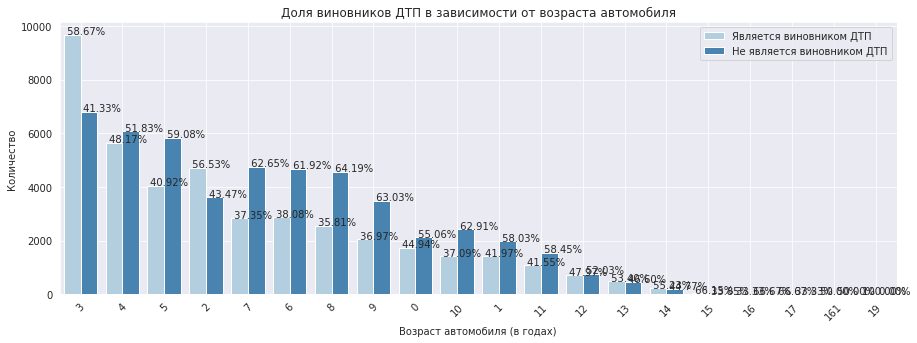

In [76]:
display(df['vehicle_age'].value_counts().to_frame().T)
get_barplot(df,'vehicle_age', rot=45)

Молодые автомобили (3-6 лет) имеют более высокую вероятность быть виновными в ДТП. Это может быть связано с более высокими скоростями, мощностью и агрессивностью водителей на таких автомобилях. В рамках системы оценки рисков можно предложить повышенное внимание к этим автомобилям.

С возрастом автомобилей вероятность ДТП уменьшается. Это может свидетельствовать о том, что с увеличением возраста автомобиля (или его использованности) возникает меньше ситуаций, в которых автомобили становятся виновными в ДТП, что также может быть связано с меньшим количеством старых автомобилей на дорогах.

Важно учитывать возраст автомобиля при создании системы оценки риска, чтобы предсказать, как вероятность ДТП будет зависеть от этой переменной, и предоставить соответствующие рекомендации водителям, основываясь на возрасте выбранного автомобиля.



#### Тип кузова

,sedan,coupe,other
vehicle_type,45821,44892,19


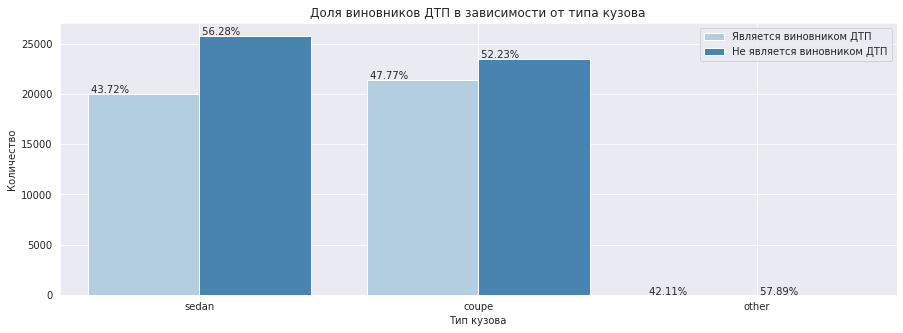

In [77]:
display(df['vehicle_type'].value_counts().to_frame().T)
get_barplot(df,'vehicle_type')

Седаны и купе имеют высокую долю виновников ДТП, особенно седаны, где доля виновников составляет более 56%. Это может означать, что водители на таких автомобилях чаще становятся виновниками ДТП.
Другие типы кузова имеют меньшую долю виновников ДТП, однако количество таких автомобилей в данных незначительно.


Тип кузова имеет важное значение для оценки риска ДТП. Седаны и купе имеют высокую долю виновников ДТП, особенно седаны, где доля виновников составляет более 56%. Это может означать, что водители на таких автомобилях чаще становятся виновниками ДТП.

Если система оценки риска ориентируется на тип кузова, это может помочь создать более точные рекомендации для водителей, например, выбирать менее рискованные автомобили для высокорисковых ситуаций (например, на высокоскоростных трассах или в условиях плохой видимости).


,auto,manual
vehicle_transmission,47098,43634


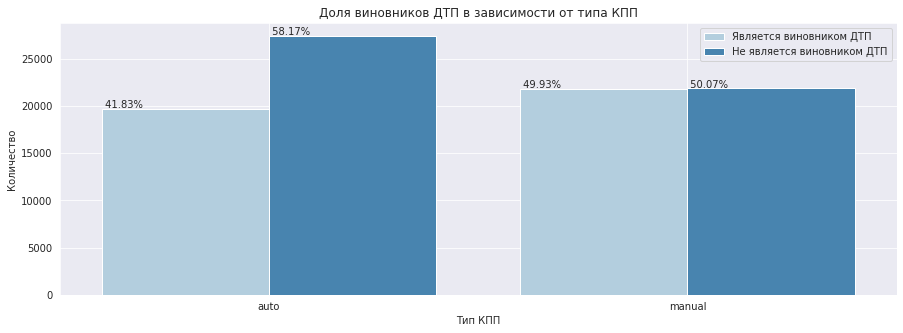

In [78]:
display(df['vehicle_transmission'].value_counts().to_frame().T)
get_barplot(df, 'vehicle_transmission')

Автомобили с автоматической коробкой передач имеют более высокую вероятность стать виновниками ДТП, с долей 58.17% виновников, что значительно больше, чем у автомобилей с механической коробкой передач. Это может быть связано с тем, что водители на таких автомобилях могут проявлять большую агрессивность или превышать скорость.


Механическая коробка передач имеет более сбалансированную долю виновников и невиновных — примерно 50% автомобилей с механической коробкой передач становятся виновниками ДТП. Это может указывать на то, что водители с механической коробкой передач имеют более контролируемое поведение за рулем, хотя и не избежать аварий. Также, так как механическая коробка передач устанавливается на более старые автомобили они требуют больший навык управления, что также может снижать колличество ДТП.

При оценке риска можно учесть, что автомобили с автоматической коробкой передач могут иметь более высокий риск, и стоит добавить дополнительные меры безопасности или рекомендации для водителей таких автомобилей.


## Выводы

**Описание таблиц**  
• **collisions** — информация о ДТП
Содержит уникальный идентификатор `case_id`. Эта таблица содержит общую информацию о ДТП, например, место и время происшествия.
• **parties** — информация об участниках ДТП   
Имеет неуникальный `case_id`, который связан с конкретным ДТП из таблицы `collisions`. Каждая строка соответствует одной из сторон, участвующих в происшествии. Если в ДТП участвовали два автомобиля, в этой таблице будет две строки с одинаковым `case_id`. Для уникальной идентификации используется комбинация `case_id` и `party_number`.
• **vehicles** — информация о пострадавших автомобилях  
Содержит неуникальные `case_id` и `party_number`, которые связаны с таблицами `collisions` и `parties`. Для уникальной идентификации используется комбинация `case_id` и `party_number`.

**Первичное исследование таблиц**:
- Все загруженные таблицы содержат данные.  
- Количество таблиц и типы данных соответствуют требованиям задачи.
- Таблица `case_ids` содержит данные только за 2021 год.

**Статистический анализ факторов ДТП**:   
- Весна и зима — сезоны с наибольшим количеством аварий, а октябрь также является месяцем с высоким числом ДТП.  
- Для автомобилей от 3 до 8 лет вероятность стать виновником ДТП снижается с увеличением возраста транспортного средства, но после 8 лет эта вероятность возрастает.  
- Неблагоприятные погодные условия увеличивают вероятность быть виновником ДТП.

**Предобработка данных**:  
- обработка пропусков:  
    - `direction`, `location_type`, - заполнены значением `unknown`;  
    - `vehicle_transmission` - значением `auto`;   
    - `vehicle_age` - модой в зависимости от географического района, типа кузова и типа КПП;  
    - пропуски в остальных столбцах были удалены;  
- После разделения данных на выборки из `train` были удалены аномальные значения и заполнены пропуски 
- после предобработки сохранилось примерно 88% данных; 

**Создание модели для оценки водительского риска**:   
- Были подобраны гиперпараметры для моделей случайного леса, градиентного бустинга и логистической регрессии.  
- В ходе кросс-валидации лучший результат показала модель `CatBoostClassifier`.
- Для повышения охвата потенциальных виновников ДТП было принято решение понизить порог классификации.
- Результаты на тестовой выборке:
    - `roc_auc` = 66;  
    - `f1` = 63;  
    - `precision` = 50;  
    - `recall` = 85.  
 
Для создания эффективной системы оценки риска при выдаче автомобиля необходимы данные о случаях, не приведших к ДТП. Также в данных в основном содержится информация о транспортных средствах и обстоятельствах аварии, но отсутствует информация о клиенте.